### Import Libraries

In [1]:
import numpy as np
import xarray as xr
import hsmm_mvpy as hmp
import matplotlib.pyplot as plt
from pathlib import Path
from mne import channels

### Load data

In [22]:
# Amount of cores to use in multiprocessing
cpus = 24

eeg_data = xr.load_dataset('data/sat1/data22-25.nc')

# Set up montage according to 10-20 system
montage = dict(channels.make_standard_montage('easycap-M1').get_positions())['ch_pos']

# Load x and y positions of electrodes
positions = np.array([montage[x][:2] for x in eeg_data['electrodes'].values])


### Prepare data

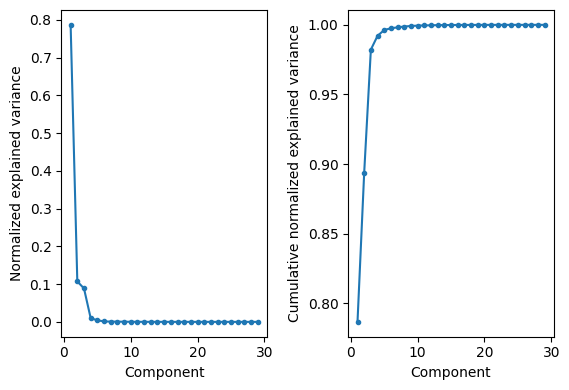

In [23]:
# Transform data into principal component (PC) space
# will ask in a pop-up how many components to keep
# selection depends on data size, choose number at cutoff (90/99%) or at 'elbow' point
hmp_data = hmp.utils.transform_data(eeg_data)

### Initialize model

In [24]:
model_all = hmp.models.hmp(hmp_data, eeg_data, event_width=50, cpus=cpus,
                                 sfreq=eeg_data.sfreq)

hmp_accuracy_data = hmp.utils.condition_selection(hmp_data, eeg_data, 'AC')
model_accuracy = hmp.models.hmp(hmp_accuracy_data, eeg_data, event_width=50, cpus=cpus,
                                 sfreq=eeg_data.sfreq, estimate_magnitudes=False)

hmp_speed_data = hmp.utils.condition_selection(hmp_data, eeg_data, 'SP')
model_speed = hmp.models.hmp(hmp_speed_data, eeg_data, event_width=50, cpus=cpus,
                              sfreq=eeg_data.sfreq, estimate_magnitudes=False)


#### LOOCV

In [20]:
estimates = model_all.fit(step=1)


  0%|          | 0/72 [00:00<?, ?it/s]

Transition event 2 found around sample 26
Transition event 3 found around sample 41
Transition event 4 found around sample 65
Estimating 4 events model
Parameters estimated for 4 events model


Estimating 8 events model with 1 starting point(s)
Parameters estimated for 8 events model


C:\GIT\hsmm_mvpy\src\hsmm_mvpy\models.py:403: RuntimeWarning: divide by zero encountered in log
  likelihood = np.sum(np.log(eventprobs.sum(axis=0)))#sum over max_samples to avoid 0s in log
C:\GIT\hsmm_mvpy\src\hsmm_mvpy\models.py:404: RuntimeWarning: invalid value encountered in divide
  eventprobs = eventprobs / eventprobs.sum(axis=0)
C:\GIT\hsmm_mvpy\src\hsmm_mvpy\models.py:313: RuntimeWarning: invalid value encountered in scalar subtract
  while lkh - lkh_prev > threshold and i < max_iteration:#Expectation-Maximization algorithm


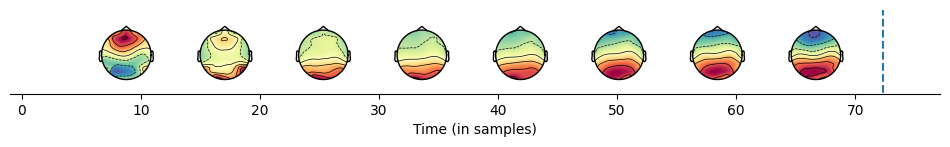

In [18]:
max_fit = model_all.fit_single(n_events=8)
hmp.visu.plot_topo_timecourse(eeg_data, max_fit, positions, model_all)


In [21]:
bests = model_all.backward_estimation()


Estimating all solutions for maximal number of events (6) with 1 pre-defined starting point and 0 random starting points
Estimating all solutions for 5 number of events


C:\GIT\hsmm_mvpy\src\hsmm_mvpy\models.py:403: RuntimeWarning: divide by zero encountered in log
  likelihood = np.sum(np.log(eventprobs.sum(axis=0)))#sum over max_samples to avoid 0s in log
C:\GIT\hsmm_mvpy\src\hsmm_mvpy\models.py:404: RuntimeWarning: invalid value encountered in divide
  eventprobs = eventprobs / eventprobs.sum(axis=0)
C:\GIT\hsmm_mvpy\src\hsmm_mvpy\models.py:313: RuntimeWarning: invalid value encountered in scalar subtract
  while lkh - lkh_prev > threshold and i < max_iteration:#Expectation-Maximization algorithm


KeyError: "not all values found in index 'event'"

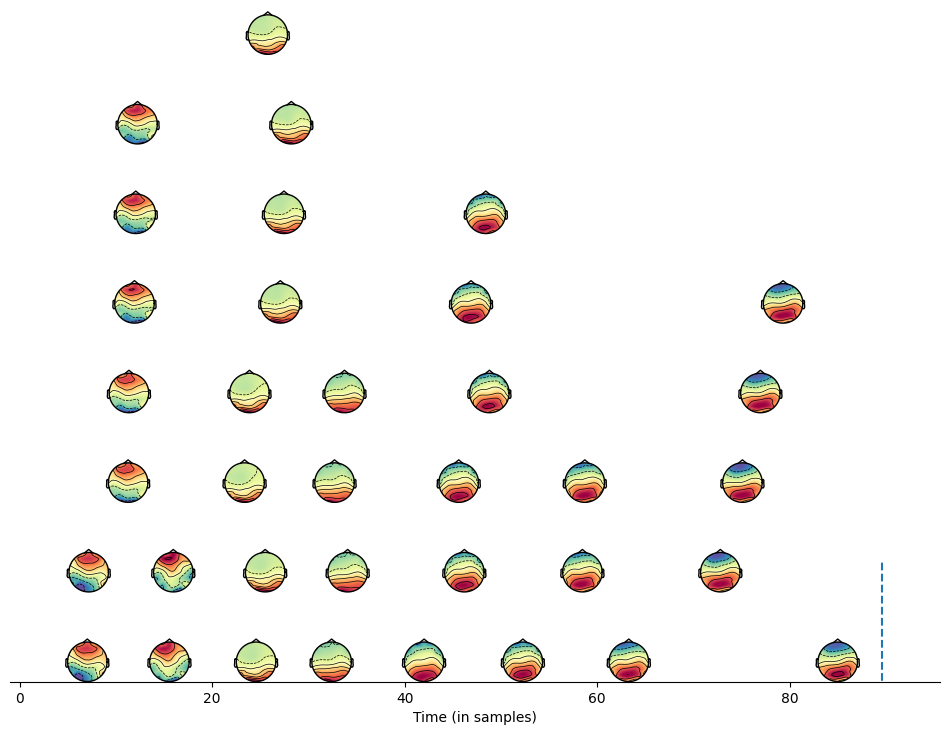

In [12]:
hmp.visu.plot_topo_timecourse(eeg_data, bests, positions, model_accuracy, ydim='n_events')

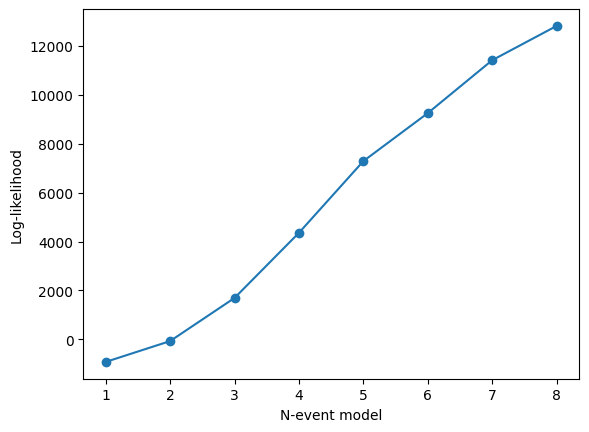

In [23]:
plt.plot(bests.n_events, bests.likelihoods,'o-')

plt.ylabel('Log-likelihood')
plt.xlabel('N-event model')
plt.show()

In [31]:
loocv = hmp.utils.loocv_mp(model_all, hmp_data, bests, cpus=4)

LOOCV for model with 8 event(s)


ValueError: operands could not be broadcast together with shapes (15151,8) (15151,0) 

#### Regular fitting

In [25]:
# fit_all = model_all.fit(step=1)

fit_accuracy = model_accuracy.fit(step=1)

fit_speed = model_speed.fit(step=1)

  0%|          | 0/89 [00:00<?, ?it/s]

Transition event 2 found around sample 27
Transition event 3 found around sample 45
Transition event 4 found around sample 70
Estimating 4 events model
Parameters estimated for 4 events model


  0%|          | 0/53 [00:00<?, ?it/s]

Transition event 2 found around sample 25
Transition event 3 found around sample 46
Estimating 3 events model
Parameters estimated for 3 events model


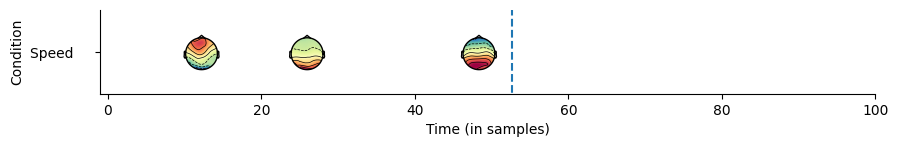

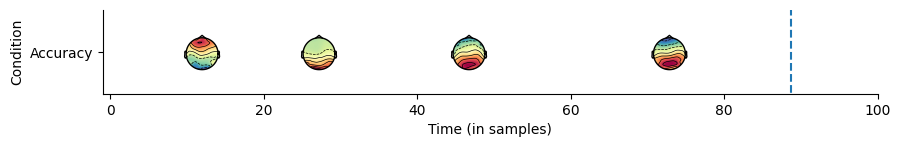

In [26]:
for condition in zip([fit_speed, fit_accuracy],
                     [model_speed, model_accuracy],
                     [hmp_speed_data, hmp_accuracy_data],
                    ['Speed    ', 'Accuracy']):
    hmp.visu.plot_topo_timecourse(eeg_data, condition[0],
                          positions, condition[1],  
                          times_to_display = np.mean(condition[1].ends - condition[1].starts),max_time=100,
                          figsize=(10,1), ylabels={'Condition':[condition[3]]})

In [80]:
eeg_data

<xarray.Dataset>
Dimensions:      (epochs: 200, electrodes: 30, samples: 210, participant: 4)
Coordinates:
  * epochs       (epochs) int64 0 1 2 3 4 5 6 7 ... 193 194 195 196 197 198 199
  * electrodes   (electrodes) object 'Fp1' 'Fp2' 'AFz' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) int32 0 1 2 3 4 5 6 7 ... 203 204 205 206 207 208 209
  * participant  (participant) object '0022' '0023' '0024' '0025'
Data variables:
    data         (participant, epochs, electrodes, samples) float64 3.19e+06 ...
    event        (participant, epochs) object 'AC/stim_right/resp_right' ... ...
Attributes:
    sfreq:    100
    offset:   0

In [41]:
fit_accuracy

<xarray.Dataset>
Dimensions:              (stage: 5, parameter: 2, event: 4, component: 4,
                          trial_x_participant: 374, samples: 210)
Coordinates:
  * event                (event) int32 0 1 2 3
  * samples              (samples) int32 0 1 2 3 4 5 ... 204 205 206 207 208 209
  * trial_x_participant  (trial_x_participant) object MultiIndex
  * participant          (trial_x_participant) object '0022' '0022' ... '0025'
  * trials               (trial_x_participant) int64 0 3 4 5 ... 174 175 179 181
Dimensions without coordinates: stage, parameter, component
Data variables:
    likelihoods          float64 4.439e+03
    parameters           (stage, parameter) float64 2.0 4.971 2.0 ... 2.0 9.408
    magnitudes           (event, component) float64 -1.702 -0.07806 ... -1.264
    eventprobs           (trial_x_participant, samples, event) float64 0.0 .....

In [108]:
# plt.plot(fit_accuracy.eventprobs[100,:,:])
# plt.show()
# print(fit_accuracy.eventprobs[100,:,:])

# for trial in fit_accuracy.eventprobs:
#     print(np.array(trial.idxmax(dim='samples')))
# eeg_data_txp.sel(samples=slice(1,10))
eeg_slice

NameError: name 'eeg_slice' is not defined

In [123]:
# Takes a model and the probabilities of events occuring within the dataset the model was initiated on
# and returns an ndarray of shape samples x time x #electrodes
# length of labels must be equal to amount of events
def process_model(model, eeg_data, labels):
    n_events = len(model.event)
    if len(labels) != n_events:
        return ValueError('Amount of labels is not equal to amount of events, adjust labels parameter')
    
    # Set up output datatypes
    event_locations = model.eventprobs.idxmax(dim='samples')
    stage_labels = []
    stage_data = np.zeros((len(event_locations), len(model.samples), len(eeg_data.electrodes)), dtype=np.float64)
    print(stage_data.shape)

    for i, (locations, data) in enumerate(zip(event_locations, model.trial_x_participant)):
        data = data.item()
        print(f'Processing participant {data[0]} and epoch {data[1]}')
        eeg_data_txp = eeg_data.sel(participant=data[0], epochs=data[1])
        # print(eeg_data_txp)
        for j, location in enumerate(locations):
            location = location.item()

            # print(f'{j}, {location}')
            if j == 0:
                prev_location = location
            else:
                stage_labels.append(labels[j - 1])
                # print(eeg_data_txp[prev_location:location])
                # Ordering of slice/stage names is not correct
                eeg_slice = eeg_data_txp.sel(samples=slice(prev_location, location))['data'].T
                stage_data[i,0:len(eeg_slice),:] = eeg_slice
                prev_location = location
    
    return stage_data, stage_labels

acc_data, acc_labels = process_model(fit_accuracy, eeg_data, ['perception', '2', '3', 'motor'])

(374, 210, 30)
Processing participant 0022 and epoch 0
Processing participant 0022 and epoch 3
Processing participant 0022 and epoch 4
Processing participant 0022 and epoch 5
Processing participant 0022 and epoch 6
Processing participant 0022 and epoch 7
Processing participant 0022 and epoch 9
Processing participant 0022 and epoch 12
Processing participant 0022 and epoch 13
Processing participant 0022 and epoch 15
Processing participant 0022 and epoch 18
Processing participant 0022 and epoch 19
Processing participant 0022 and epoch 21
Processing participant 0022 and epoch 22
Processing participant 0022 and epoch 24
Processing participant 0022 and epoch 26
Processing participant 0022 and epoch 27
Processing participant 0022 and epoch 30
Processing participant 0022 and epoch 32
Processing participant 0022 and epoch 33
Processing participant 0022 and epoch 37
Processing participant 0022 and epoch 38
Processing participant 0022 and epoch 43
Processing participant 0022 and epoch 45
Processi

In [71]:
# Wanted to find maximum indices of each trial x epoch x bump
maxes = fit_speed.eventprobs.max(dim=['samples', 'bump'])

<xarray.DataArray 'eventprobs' (trial_x_participant: 348)>
array([0.16335439, 0.22371889, 0.38479025, 0.37012163, 0.21095929,
       0.3893892 , 0.30537582, 0.22335267, 0.28161743, 0.16573711,
       0.35493709, 0.29446335, 0.36478153, 0.31608389, 0.27405819,
       0.30551119, 0.29411397, 0.20232854, 0.26509706, 0.38689649,
       0.30838448, 0.34468386, 0.37405469, 0.4642212 , 0.35573854,
       0.26861993, 0.33936066, 0.25724585, 0.3711087 , 0.35030771,
       0.31066391, 0.25164012, 0.41131994, 0.20861407, 0.34679127,
       0.28371838, 0.23184702, 0.32196759, 0.44051461, 0.23100195,
       0.23036585, 0.3480755 , 0.25749315, 0.28691498, 0.33831863,
       0.25596993, 0.37131498, 0.28183487, 0.37873544, 0.30997321,
       0.32254625, 0.28978561, 0.31325281, 0.32996417, 0.3597454 ,
       0.42744259, 0.16963467, 0.37141571, 0.34619434, 0.2749084 ,
       0.31440021, 0.3632025 , 0.18984907, 0.39935222, 0.21291138,
       0.381393  , 0.21585839, 0.23430742, 0.29196241, 0.25928897,
   

### LOOCV